### Evaluate Simple ML Models on the DUD-E Kinase Datasets
Build models for each of the DUD-E kinase datasets and evaluate the ability of these models to separate actives from decoys on the remaining DUD-E kinase datasets. 

In [1]:
import pandas as pd
import useful_rdkit_utils as uru
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import roc_auc_score
from rdkit.rdBase import BlockLogs
from tqdm.auto import tqdm
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

Read in the similarities calculated using **analyze_kinases.py**

In [2]:
seq_sim_df = pd.read_csv("kinase_similarities.csv")

Reshape the data and plot a boxplot of the similarities

/var/folders/nt/jm11nt2n47j1bwkv659008hr0000gn/T/ipykernel_34915/2255775738.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


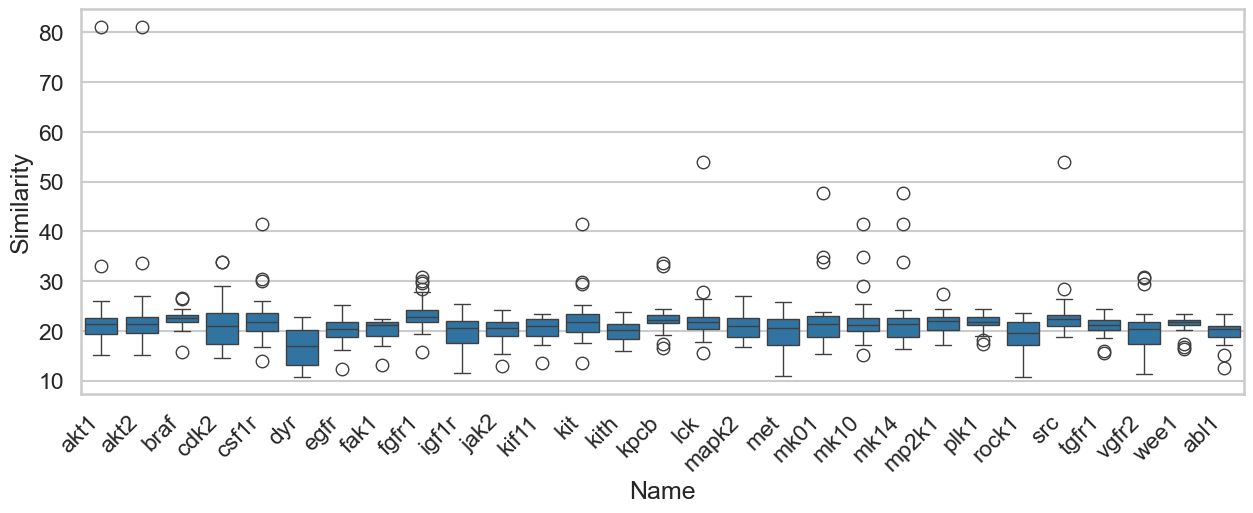

In [3]:
# 1. Melt the dataframe from wide to long format
# We keep 'Name' as the identifier and collapse all other kinase columns into one 'AUC' column
df_long = seq_sim_df.melt(id_vars='Name', var_name='Target', value_name='Similarity')

# 2. Remove diagonal elements
# This filters out rows where the kinase name matches the target column
df_long = df_long[df_long['Name'] != df_long['Target']]

# 3. Display as boxplot (similar to your previous plot setup)
plt.figure(figsize=(15, 5))
sns.set_context('talk')
sns.set_style('whitegrid')
ax = sns.boxplot(x="Name", y="Similarity", data=df_long)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

Define a variable pointing to the DUD-E directories

In [4]:
df_long.sort_values("Similarity",ascending=False).head(10)

,Name,Target,Similarity
59,akt1,akt2,81.120332
31,akt2,akt1,81.120332
489,src,lck,53.903346
741,lck,src,53.903346
572,mk14,mk01,47.696477
628,mk01,mk14,47.696477
601,mk14,mk10,41.577825
629,mk10,mk14,41.577825
382,csf1r,kit,41.410129
158,kit,csf1r,41.410129


In [5]:
DUDE_DIRECTORY = "/Users/pwalters/DATA/DUD-E/all"

Read the input data

In [6]:
target_df = pd.read_csv("dud-e.target_class.csv")
target_df.columns = [x.replace(" ","_") for x in target_df.columns]

Extract the kinase targets

In [7]:
kinase_df = target_df.query("Target_Class == 'Kinase'").sort_values("Target_Name")

In [8]:
len(kinase_df)

28

A function to calculate descriptors

In [9]:
def read_data(dirname):
    active_df = pd.read_csv(f"{dirname}/actives_final.ism",sep=" ",names=["SMILES","Cmpd_ID","ChEMBL_ID"])
    active_df['active'] = 1
    decoy_df = pd.read_csv(f"{dirname}/decoys_final.ism",sep=" ",names=["SMILES","Cmpd_ID","ChEMBL_ID"])
    decoy_df['active'] = 0
    combo_df = pd.concat([active_df, decoy_df]).reset_index()
    smi2fp = uru.Smi2Fp()
    with BlockLogs():
        combo_df['fp'] = combo_df.SMILES.apply(smi2fp.get_np_counts)
        combo_df.dropna(subset="fp",inplace=True)
    return combo_df

Read the data and calculate descriptors

In [10]:
kinase_df_list = []
for dirname in tqdm(kinase_df.Target_Name):
    row_df = read_data(f"{DUDE_DIRECTORY}/{dirname}")
    row_df['target'] = dirname
    kinase_df_list.append(row_df)

  0%|          | 0/28 [00:00<?, ?it/s]

Build a model using each of the kinase DUD-E datasts

In [11]:
model_list = []
for df in tqdm(kinase_df_list):
    cls = LGBMClassifier(verbose=-1)
    cls.fit(np.stack(df.fp),df.active)
    target_name = df.target.values[0]
    model_list.append([cls,target_name])

  0%|          | 0/28 [00:00<?, ?it/s]

Evaluate the models on the remaining datasets

In [12]:
kinase_result_list = []
for model, target_name in tqdm(model_list):    
    for df in kinase_df_list:
        if df.target.values[0] == target_name:
            continue
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UserWarning)
            pred = model.predict_proba(np.stack(df.fp))[:,1]
        auc = roc_auc_score(df.active,pred)
        kinase_result_list.append([target_name,auc])

  0%|          | 0/28 [00:00<?, ?it/s]

In [13]:
kinase_result_df = pd.DataFrame(kinase_result_list,columns=["Target","AUC"])

Plot the Area Under the Receiver Operating Characteristic (AUC) for each of the kinase models when evaluated against the actives and decoys for the other DUD-E kinase datasets

/var/folders/nt/jm11nt2n47j1bwkv659008hr0000gn/T/ipykernel_25496/369294459.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


(0.0, 1.0)

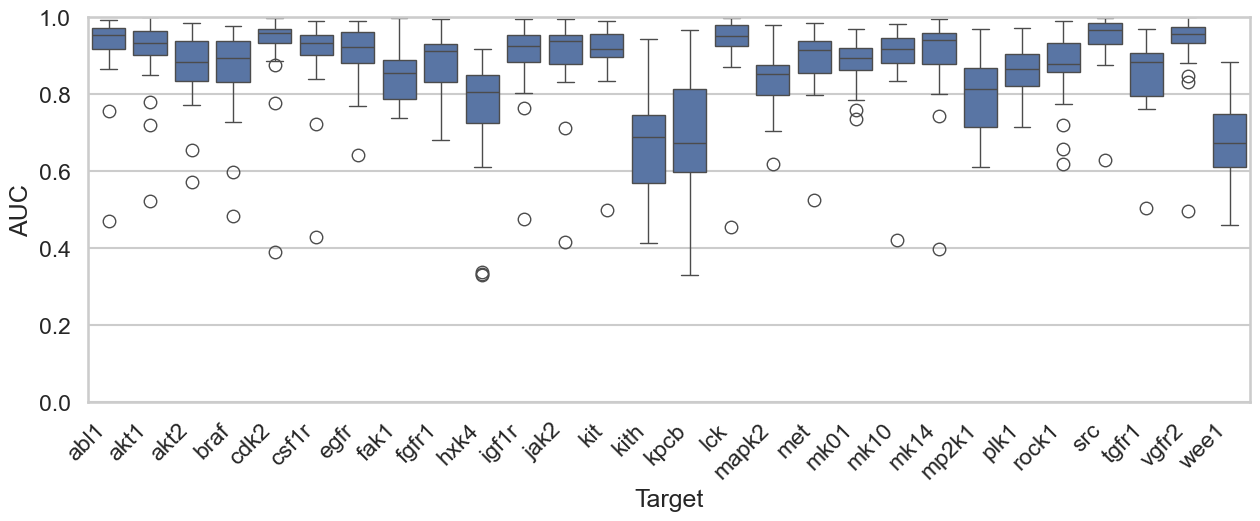

In [14]:
sns.set(rc={'figure.figsize': (15, 5)})
sns.set_style('whitegrid')
sns.set_context('talk')
ax = sns.boxplot(x="Target",y="AUC",data=kinase_result_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_ylim(0,1)

Read the DUD-E nuclear receptor datasets and calculate descriptors

In [15]:
nr_df = target_df.query("Target_Class == 'Nuclear Receptor'").sort_values("Target_Name")

In [16]:
nr_df_list = []
for dirname in tqdm(nr_df.Target_Name):
    row_df = read_data(f"{DUDE_DIRECTORY}/{dirname}")
    row_df['target'] = dirname
    nr_df_list.append(row_df)

  0%|          | 0/11 [00:00<?, ?it/s]

Use the kinase models to classify nuclear receptor ligands

In [17]:
nr_result_list = []
for df in tqdm(nr_df_list):
    target_name = df.target.values[0]
    for model,_ in model_list:    
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UserWarning)
            pred = model.predict_proba(np.stack(df.fp))[:,1]
        auc = roc_auc_score(df.active,pred)
        nr_result_list.append([target_name,auc])

  0%|          | 0/11 [00:00<?, ?it/s]

In [19]:
nr_result_df = pd.DataFrame(nr_result_list,columns=["Target","AUC"])

Plot the results for classification of the nuclear receptor databases with kinase models

/var/folders/nt/jm11nt2n47j1bwkv659008hr0000gn/T/ipykernel_25496/4205869146.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


(0.0, 1.0)

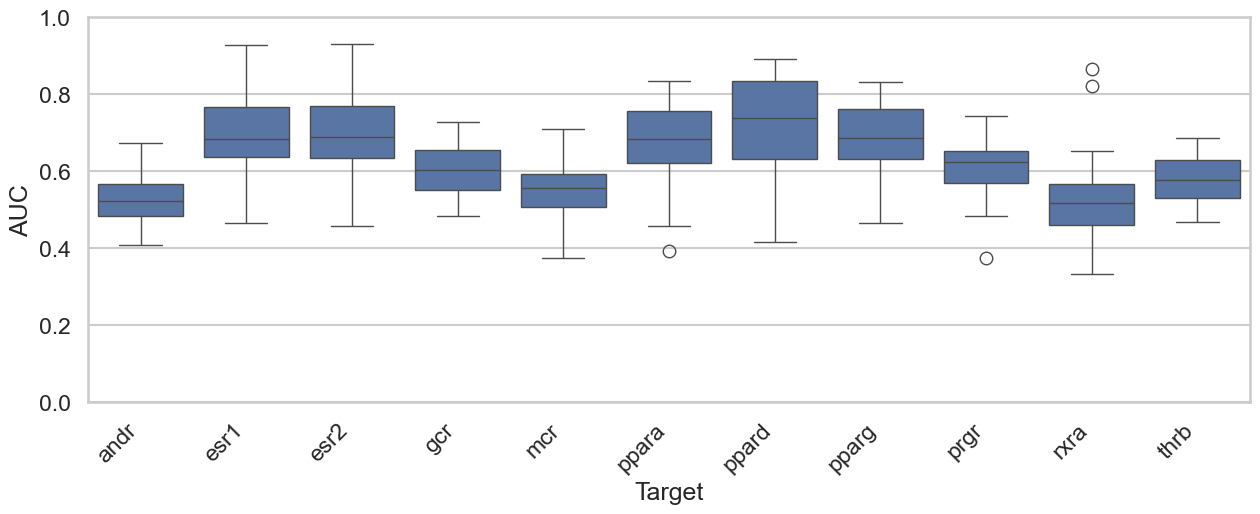

In [20]:
sns.set(rc={'figure.figsize': (15, 5)})
sns.set_style('whitegrid')
sns.set_context('talk')
ax = sns.boxplot(x="Target",y="AUC",data=nr_result_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_ylim(0,1)